## 빅데이터 활용 AI 설계
# 강화학습 : catch 게임 keras 학습

- Deep Learning with Keras (Gulli), Chapter 8. AI Game Playing
- https://github.com/PacktPublishing/Deep-Learning-with-Keras (예제 소스)
- https://gist.github.com/EderSantana/c7222daa328f0e885093 (참고 사이트)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygame
import collections

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from scipy.misc import imresize

In [3]:
pygame.init()

COLOR_WHITE = (255,255,255)
COLOR_BALCK = (0,0,0)

font = pygame.font.SysFont('Comic Sans MS', 30)

In [4]:
def step(action):
    game_over = False
    reward = 0

    global paddle_x, ball_x, ball_y, num_tries, game_score

    pygame.event.pump()

    paddle_x += (action-1)*paddle_velocity
    if paddle_x < 0:
        paddle_x = paddle_velocity
    if paddle_x > 400-50:
        paddle_x = 400-50-paddle_velocity

    screen.fill(COLOR_BALCK)

    ball_y += ball_velocity
    ball = pygame.draw.rect(screen, COLOR_WHITE, pygame.Rect(ball_x, ball_y, 20, 20))
    paddle = pygame.draw.rect(screen, COLOR_WHITE, pygame.Rect(paddle_x, 350, 50, 10))

    if ball_y >= 340:
        reward = 1 if ball.colliderect(paddle) else -1
        game_score += reward

        ball_x = np.random.randint(400-20)
        ball_y = 10

        num_tries += 1
        game_over=True

    pygame.display.flip()

    frame = pygame.surfarray.array2d(screen)
    clock.tick(30) # delay for 30 milliseconds

    return frame, reward, game_over

### Keras 적용

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import Adam

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=8, strides=4, kernel_initializer='normal',
                padding='same', input_shape=[80,80,4], activation='relu')) # (80,80,4) -> (20,20,32)
model.add(Conv2D(64, kernel_size=4, strides=2, kernel_initializer='normal',
                padding='same', activation='relu'))                        # (10,10,64)
model.add(Conv2D(64, kernel_size=3, strides=1, kernel_initializer='normal',
                padding='same', activation='relu'))                        # (10,10,64)
model.add(Flatten())
model.add(Dense(512, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal')) # Q values for left(0), stay(1), right(2)

In [7]:
#model.compile(loss='mse', optimizer=Adam(lr=1e-6))
model.compile(loss='mse', optimizer='rmsprop')

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3277312   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 3,356,835
Trainable params: 3,356,835
Non-trainable params: 0
_________________________________________________________________


- predict() 테스트

In [9]:
a = np.random.rand(1,80,80,4)
q = model.predict(a)

In [10]:
q

array([[ 0.38822764, -0.23014373, -0.33331907]], dtype=float32)

### 학습 실행
- 에포크 한번에 45초 정도 걸림

In [11]:
num_wins = 0
epsilon = 0.1 # 랜덤 행동 선택 확률
gamma = 0.99  # discount factor (미래 보상 비율)
experience = collections.deque(maxlen=50000)
losses = []
epochs = 400

for epoch in range(epochs): # ~100: observe, 100~ : train
    # game reset
    frames = collections.deque(maxlen=4)
    
    paddle_x = 200
    ball_x = np.random.randint(400-20)
    ball_y = 10 # ceiling
    paddle_velocity = 20
    ball_velocity = 10
    
    num_tries = 0
    game_score = 0
    game_over = False
    first_frame = True
    loss = 0.0

    screen = pygame.display.set_mode((400,400))
    clock = pygame.time.Clock()
    
    # game restart
    while not game_over:
        if not first_frame: s_tm1 = s_t
        
        if epoch<100:
            a_t = np.random.randint(3)
        else:
            if np.random.rand()<=epsilon or first_frame:
                a_t = np.random.randint(3)
            else:
                q = model.predict(s_t)[0]
                a_t = np.argmax(q)  # 0: left, 1: stay, 2: right
        
        # DO ACTION!!
        frame, r_t, game_over = step(a_t) # r_t -> 1: win, -1: lose, 0: playing
        
        if r_t == 1: num_wins += 1
        
        img = (imresize(frame, [80,80]).astype('float'))/255.
        if len(frames)==0:
            for i in range(4): frames.append(img) # 게임 시작시 4 프레임을 모두 첫화면으로 채운다 
        else:
            frames.append(img)
        
        s_t = np.moveaxis(np.array(frames), 0, 2) # (4,80,80) -> (80,80,4)
        s_t = np.expand_dims(s_t, axis=0) # (1,80,80,4)
        
        if first_frame:
            first_frame=False
            continue
            
        ### 첫화면이 아닐 때 실행
        experience.append([s_tm1, a_t, r_t, s_t, game_over])
            
        if epoch >= 100:
            ### batch size is 32
            indices = np.random.randint(len(experience), size=32)
            batch = [experience[i] for i in indices]
            
            X = np.zeros([32,80,80,4])
            Y = np.zeros([32,3])
            
            for i in range(32):
                b_s_t, b_a_t, b_r_t, b_s_tp1, b_game_over = batch[i]
                X[i] = b_s_t
                Y[i] = model.predict(b_s_t)[0]
                if b_game_over:
                    Y[i,b_a_t] = b_r_t
                else:
                    Y[i,b_a_t] = b_r_t + gamma*np.max(model.predict(b_s_tp1)[0])
                    
            loss += model.train_on_batch(X, Y)
        
    if epsilon > 0.0001:
        epsilon -= (0.1 - 0.0001)/epochs
        
    print('Epoch: %04d/%d | Loss: %.5f | Total Wins: %d' % (epoch+1,epochs, loss, num_wins))
    losses.append(loss)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch: 0001/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0002/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0003/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0004/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0005/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0006/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0007/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0008/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0009/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0010/400 | Loss: 0.00000 | Total Wins: 0
Epoch: 0011/400 | Loss: 0.00000 | Total Wins: 1
Epoch: 0012/400 | Loss: 0.00000 | Total Wins: 1
Epoch: 0013/400 | Loss: 0.00000 | Total Wins: 2
Epoch: 0014/400 | Loss: 0.00000 | Total Wins: 2
Epoch: 0015/400 | Loss: 0.00000 | Total Wins: 3
Epoch: 0016/400 | Loss: 0.00000 | Total Wins: 3
Epoch: 0017/400 | Loss: 0.00000 | Total Wins: 3
Epoch: 0018/400 | Loss: 0.00000 | Total Wins: 3
Epoch: 0019/400 | Loss: 0.00000 | Total Wins: 3
Epoch: 0020/400 | Loss: 0.00000 | Total Wins: 4
Epoch: 0021/400 | Loss: 0.00000 | Total 

Epoch: 0165/400 | Loss: 0.27807 | Total Wins: 30
Epoch: 0166/400 | Loss: 0.31129 | Total Wins: 30
Epoch: 0167/400 | Loss: 0.18475 | Total Wins: 30
Epoch: 0168/400 | Loss: 2.42979 | Total Wins: 31
Epoch: 0169/400 | Loss: 0.90435 | Total Wins: 32
Epoch: 0170/400 | Loss: 0.24474 | Total Wins: 32
Epoch: 0171/400 | Loss: 0.17936 | Total Wins: 32
Epoch: 0172/400 | Loss: 0.18117 | Total Wins: 33
Epoch: 0173/400 | Loss: 3.04681 | Total Wins: 33
Epoch: 0174/400 | Loss: 0.23091 | Total Wins: 33
Epoch: 0175/400 | Loss: 0.23696 | Total Wins: 34
Epoch: 0176/400 | Loss: 0.19957 | Total Wins: 35
Epoch: 0177/400 | Loss: 0.21154 | Total Wins: 35
Epoch: 0178/400 | Loss: 0.13237 | Total Wins: 35
Epoch: 0179/400 | Loss: 0.17262 | Total Wins: 35
Epoch: 0180/400 | Loss: 0.20515 | Total Wins: 35
Epoch: 0181/400 | Loss: 0.08500 | Total Wins: 35
Epoch: 0182/400 | Loss: 0.19197 | Total Wins: 36
Epoch: 0183/400 | Loss: 0.12477 | Total Wins: 36
Epoch: 0184/400 | Loss: 0.15211 | Total Wins: 37
Epoch: 0185/400 | Lo

Epoch: 0331/400 | Loss: 0.07094 | Total Wins: 171
Epoch: 0332/400 | Loss: 0.08962 | Total Wins: 172
Epoch: 0333/400 | Loss: 0.10128 | Total Wins: 173
Epoch: 0334/400 | Loss: 0.07521 | Total Wins: 174
Epoch: 0335/400 | Loss: 0.08981 | Total Wins: 175
Epoch: 0336/400 | Loss: 0.06786 | Total Wins: 176
Epoch: 0337/400 | Loss: 0.10185 | Total Wins: 177
Epoch: 0338/400 | Loss: 0.10372 | Total Wins: 178
Epoch: 0339/400 | Loss: 0.04430 | Total Wins: 179
Epoch: 0340/400 | Loss: 0.05934 | Total Wins: 180
Epoch: 0341/400 | Loss: 0.05126 | Total Wins: 181
Epoch: 0342/400 | Loss: 0.09110 | Total Wins: 182
Epoch: 0343/400 | Loss: 0.04790 | Total Wins: 183
Epoch: 0344/400 | Loss: 0.07224 | Total Wins: 184
Epoch: 0345/400 | Loss: 0.05431 | Total Wins: 185
Epoch: 0346/400 | Loss: 0.06039 | Total Wins: 186
Epoch: 0347/400 | Loss: 0.05092 | Total Wins: 187
Epoch: 0348/400 | Loss: 0.03789 | Total Wins: 188
Epoch: 0349/400 | Loss: 0.07112 | Total Wins: 189
Epoch: 0350/400 | Loss: 0.10984 | Total Wins: 190


In [12]:
pygame.quit()

### 평가

In [13]:
rewards = np.array([experience[i][2] for i in range(len(experience)) if i%32==31])

(-19.950000000000003, 418.95, -11.950000000000001, 250.95)

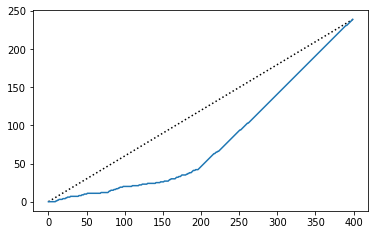

In [14]:
plt.plot([0,epochs-1], [0,num_wins], 'k:')
plt.plot(np.cumsum(rewards==1))
plt.axis('scaled')

In [15]:
len(experience)

12800

### 모델 저장 및 로딩

In [16]:
rs = [experience[2] for i in range(len(experience))]
len(rs)

12800

In [17]:
np.save('rewards.npy', rs)

In [18]:
model.save('catch.h5')

In [19]:
from keras.models import load_model

model2 = load_model('catch.h5')
model2.compile(loss='mse', optimizer='rmsprop')

### 개선 방안
- [카카오AI리포트]알파고를 만든 강화학습 비밀 (https://brunch.co.kr/@kakao-it/102)
- Double DQN : 목표값에 적용할 Q 값을 구할 때는 느린 모델을 적용하고, 최적의 행동을 선택할 때는 매번 훈련에 의해 갱신되는 Q 값을 적용한다. (비슷한 두개의 모델을 적용하는 것으로, 주기적으로 목표값용 모델을 업데이트 해준다.)<br>
> $ Q(s,a) = r + \gamma \cdot max_a' Q(s',a') $ => 최적 행동 결정 (빠른 모델)<br>
> $ Q'(s,a) \leftarrow Q(s,a) $ when some time elapsed => 미래 총보상값 계산 (느린 모델)<br><br>
- Dueling DQN : 현재 상태의 value-function 과 Q 값 보정치를 신경망 결과로 따로 얻는다.<br>
> $$ Q(s,a) = V(s) + A(s,a) $$<br>
- Monte Carlo Algorism : 랜덤하게 시행해 봐서 어떤 상황의 예측치를 추정하는 방식 (주사위 던지기)
- MCTS (Monte Carlo Tree Search) : 행동을 선택할 때 그냥 현재까지의 최적의 행동을 선택하는 것이 아니라, 제일 괜찮은 행동 몇가지를 뽑아내고 이 행동들에 대해 트리 서치를 이용하여 충분히 시뮬레이션을 시행한 후 그 중 시뮬레이션 결과가 가장 좋은 행동으로 최종 결정한다.